# DONE

- Make parser
- Initialize SynthTree with new chunks as paragraphs
- Run normal stuff on top

In [1]:
import base64
import os

import requests
from dotenv import load_dotenv
from openai import AsyncOpenAI
from pdf2image import convert_from_path
from sklearn.utils import gen_batches

from jasyntho.document.synthpar import SynthParagraph

load_dotenv()

# OpenAI API Key
api_key = os.getenv("OPENAI_API_KEY")


# Function to encode the image
def encode_image(image_path):
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode("utf-8")


def load_imagerange(pdf, indices):
    img_messages = []
    for i in indices:
        img_path = f".tmp/page{i}.jpg"
        base64_image = encode_image(img_path)
        img_messages.append(
            {
                "type": "image_url",
                "image_url": {"url": f"data:image/jpeg;base64,{base64_image}"},
            }
        )
    return img_messages


def calc_cost(response):
    intok = response.usage.prompt_tokens
    outtok = response.usage.completion_tokens

    incost = intok * (5 / 1e6)
    outcost = outtok * (15 / 1e6)
    return incost + outcost


from typing import Optional

from pydantic import BaseModel, Field


class Substance(BaseModel):
    name: str = Field(..., description="Name used for the substance.")
    reference_key: Optional[str] = Field(
        ..., description="Reference key used for the substance."
    )
    role: str = Field(
        ...,
        description="Role of the substance in the reaction. Can be [product, main reactant, reagent, solvent, catalyst, other].",
    )


async def vision_parse_batch(
    img_messages, model="gpt-4o", prgr_sep="##---##", client=None
):
    url = "https://api.openai.com/v1/chat/completions"
    headers = {
        "Authorization": f"Bearer {api_key}",
        "Content-Type": "application/json",
    }

    prompt = """These are some pages from the SI of an organic chemistry paper.
    Describe all the reactions shown there, if any.
    Separate each reaction with \"{}\", describe products and reactants for each reaction.
    Ignore all characterization data. Consider work-up and purification as part of the same reaction.
    Use the following format to represent the products and main reactants: {}.
    Do not rewrite the reaction procedures, just describe the substances involved."""

    messages = [
        {
            "role": "system",
            "content": "You are an expert chemist. Your task is to read and extract data from chemistry papers.",
        },
        {
            "role": "user",
            "content": [
                {
                    "type": "text",
                    "text": prompt.format(prgr_sep, Substance.schema()),
                },
                *img_messages,
            ],
        },
    ]

    response = await client.chat.completions.create(
        model=model, messages=messages, max_tokens=4096
    )
    cost = calc_cost(response)
    print(f"Finished processing batch. Cost: {cost}")
    return response.choices[0].message.content


def split_images(pdf):
    images = convert_from_path(pdf)
    # Store images into .tmp
    os.makedirs(".tmp", exist_ok=True)
    for i in range(len(images)):
        images[i].save(f".tmp/page{i}.jpg", "JPEG")
    return images


def create_overlapping_batches(N, batch_size, overlap):
    start = 0
    batches = []
    while start < N:
        end = start + batch_size
        if end > N:
            end = N
        batches.append((start, end))
        start += batch_size - overlap
    return batches


async def vision_parse(pdf, batch_size=10, model="gpt-4o", prgr_sep="##---##"):
    images = split_images(pdf)
    img_messages = []
    N = len(images)
    start = 0
    client = AsyncOpenAI()

    paragraphs = []

    # divide the images into batches
    indices = list(range(N))
    tasks = []

    for b0, b1 in create_overlapping_batches(N, batch_size, overlap=1):
        img_messages = load_imagerange(pdf, indices[b0:b1])
        tasks.append(
            vision_parse_batch(
                img_messages, model=model, prgr_sep=prgr_sep, client=client
            )
        )

    responses = await asyncio.gather(*tasks)

    for response in responses:
        paragraphs += response.split(prgr_sep)

    return [SynthParagraph(p) for p in paragraphs]

/home/andres/anaconda3/envs/jasyntho/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import asyncio
import json
import logging
import os
import re
from itertools import chain
from typing import Dict, List, Optional

import fitz  # type: ignore
import networkx as nx  # type: ignore
from colorama import Fore  # type: ignore

import wandb
from jasyntho.document.base import ResearchDoc
from jasyntho.document.si_select import SISplitter
from jasyntho.document.synthpar import SynthParagraph
from jasyntho.extract import ExtractReaction, Product
from jasyntho.extract.extended import LabConnection
from jasyntho.extract.substances import Product
from jasyntho.utils import RetrieveName, name_to_smiles

# Silence retry validator warnings
logging.getLogger("instructor").setLevel(logging.CRITICAL)


class SynthTree(ResearchDoc):
    """Extend SISynthesis to represent reaction tree."""

    products: List[Product] = []
    full_g: nx.DiGraph = nx.DiGraph()
    reach_subgraphs: Dict[str, nx.DiGraph] = {}
    rxn_extract: Optional[ExtractReaction] = None
    paragraphs: List[SynthParagraph] = []
    raw_prods: List[Product] = []
    v: bool = True

    def gather_smiles(self):
        """Gather all smiles from the products."""

        G = self.full_g

        iupac = RetrieveName()

        def get_iupac(subs, context):
            try:
                return iupac(subs, context).name
            except Exception as e:
                return []

        def _size_reach_sg(G, node):
            """Calc size of each reachable subgraph."""
            rn = set(nx.bfs_tree(G, node))
            return len(rn)

        for k, g in G.nodes.items():
            l = _size_reach_sg(G, k)
            if l > 1:
                if "attr" not in g.keys():
                    return None

                name = g["attr"]["substance_name"]
                labl = g["attr"]["reference_key"]
                smi = name_to_smiles(name, labl)
                if smi is None:
                    # Try to get iupac name
                    retrieved_names = get_iupac(k, context=g["attr"]["text"])
                    print(f"key {k}. Got iupac name: {retrieved_names}")
                    for n in retrieved_names:
                        smi = name_to_smiles(n, labl)
                        if smi:
                            # Assign iupac and smiles attributes to node
                            g["attr"]["iupac"] = n
                            g["attr"]["smiles"] = smi
                            break
                if smi is not None:
                    g["attr"]["smiles"] = smi

        self.full_g = G
        # TODO try this

    def extended_connections(self):
        """Return the extended connections for a given query."""
        dts = self.partition()
        lab_connect = LabConnection(self)

        new_connects = {}
        for k, g in dts.items():
            if len(g) > 1:
                print(f"Processing reachable subgraph from source node {k}")
                new_connects[k] = lab_connect(k)

        self.reach_subgraphs = self.partition(new_connects)
        return new_connects  # in case we want to use it later

    def partition(self, new_connects: Optional[dict] = None):
        """Merge and find all reachable subgraphs in paper.
        If dict of new connects is given, rewire the graph with new connections.
        """
        prods = self.unique_keys(self.products)
        self.full_g = self.get_full_graph(prods)

        if new_connects is not None:
            self.full_g = self._rewire(self.full_g, new_connects)

        reach_subgraph = SynthTree.get_reach_subgraphs(self.full_g)
        return reach_subgraph

    def _rewire(self, full_graph, new_connects):
        """Rewire the graph with new connections."""
        # add new edges
        for k, res in new_connects.items():
            if res is not None:
                prod_step = res["step 2"]
                if prod_step is not None:
                    prod = prod_step.product.reference_key
                    if prod in full_graph.nodes:
                        if k != prod:
                            full_graph.add_edge(prod, k)
        return full_graph

    @classmethod
    def unique_keys(cls, trees):
        """Return a list of trees with unique IDs.

        For now simply keep a unique one. the first found
        """
        ftrees = {}
        for t in trees:
            if t.reference_key not in ftrees.keys():
                ftrees[t.reference_key] = t
        return list(ftrees.values())

    def get_full_graph(
        self,
        product_list: List[Product],
        children_types: List[str] = ["reactant", "reagent", "catalyst"],
    ):
        """Build a graph using input disconnected nodes."""
        # Directed graph
        Gd = nx.DiGraph()

        # Add each node
        for p in product_list:
            # Add node with properties
            if p.reference_key is not None:
                Gd.add_node(
                    p.reference_key, attr=p.model_dump()  # type: ignore
                )
            else:
                print(f"\t- Error adding node: {p.note}")
            for c in p.children:
                if c.role_in_reaction in children_types:
                    Gd.add_edge(
                        p.reference_key,
                        c.reference_key,
                        attr={"type": "lab reaction"},
                    )
        return Gd

    @classmethod
    def get_reach_subgraphs(cls, Gd: nx.DiGraph) -> Dict[str, nx.DiGraph]:
        """
        Get a list of reachable subgraph from source nodes.

        Find all nodes with indegree==0 (heads) and find subgraph of reachable
        nodes.
        """
        # Get list of heads
        heads = [n for n, indeg in Gd.in_degree() if indeg == 0]

        for h in Gd.nodes:
            if h in heads:
                Gd.nodes[h]["is_head"] = True
            else:
                Gd.nodes[h]["is_head"] = False

        # Extract subgraphs reachable from each head node.
        def extract_subgraph(graph, start_node):
            """Use BFS to find all nodes reachable from start_node."""
            reachable_nodes = set(nx.bfs_tree(graph, start_node))
            return graph.subgraph(reachable_nodes).copy()

        # Store the subgraphs in a list
        subgraphs = {
            node: extract_subgraph(Gd, node)
            for node in Gd
            if Gd.nodes[node]["is_head"]
        }
        return subgraphs

    # Exporting
    def export(self):
        """Export the SynthTree's reachable subgraph from source nodes into JSON."""

        json = {}
        # For each reachable subgraph from source node, serialize it into JSON
        for k, g in self.reach_subgraphs.items():
            smiles = g.nodes[k]["attr"].get("smiles") or k
            json[k] = {
                "smiles": smiles,
                "type": "mol",
                "in_stock": False,
                "children": self.json_serialize(g, key=k),
            }
        return json

    def json_serialize(self, G, key="10"):
        """Serialize a single reachable subgraph from source node into JSON."""
        # TODO finish this -> convert_to_smiles, etc. Add this somewhere else so that this function is simply format translation

        json = {}
        successors = G.successors(key)
        slist = []
        for s in successors:
            props = G.nodes[s]
            if len(list(G.successors(s))) > 0:
                # Get properties of the node
                if "attr" not in props.keys():
                    continue
                name = props["attr"]["substance_name"]
                if "smiles" in props["attr"].keys():
                    smiles = props["attr"]["smiles"]
                else:
                    smiles = name

                # Format json
                slist.append(
                    {
                        "smiles": smiles,
                        "name": name,
                        "type": "mol",
                        "in_stock": False,
                        "children": self.json_serialize(G, key=s),
                    }
                )
            else:
                smiles = s
                slist.append(
                    {
                        "smiles": s,
                        "name": s,
                        "type": "mol",
                        "in_stock": False,
                    }
                )

        final_json = [{"smiles": "", "type": "reaction", "children": slist}]
        return final_json

    def select_syntheses(self) -> None:
        """Select the part of the SI where syntheses are described."""
        si_split = SISplitter()

        si_split.signal_threshold = 0.35
        si_split.window_size = 150
        if self.v:
            si_split.plot = True

        doc = self.from_dir(self.doc_src)
        relevant_si = si_split.select_relevant(doc)
        relev_si_src = os.path.join(self.doc_src, "si_syntheses.pdf")
        relevant_si.save(relev_si_src)

    def extract_rss(self) -> list:
        """Extract reaction setups for each paragraph in the doc."""
        relev_si_src = os.path.join(self.doc_src, "si_syntheses.pdf")
        self.paragraphs = self._get_paragraphs(relev_si_src)

        raw_prodlist = [p.extract(self.rxn_extract) for p in self.paragraphs]
        self.raw_prods = list(chain(*raw_prodlist))  # type: ignore

        self._log_products()
        self._report_process(self.raw_prods)
        products = [p for p in self.raw_prods if not p.isempty()]
        return products

    async def async_extract_rss(self) -> list:
        """Extract reaction setups for each paragraph in the doc."""
        relev_si_src = os.path.join(self.doc_src, "si_syntheses.pdf")
        self.paragraphs = await self._get_paragraphs(relev_si_src)

        raw_prodlist = await asyncio.gather(
            *[p.async_extract(self.rxn_extract) for p in self.paragraphs]
        )
        self.raw_prods = list(chain(*raw_prodlist))  # type: ignore

        self._log_products()
        self._report_process(self.raw_prods)
        products = [p for p in self.raw_prods if not p.isempty()]
        return products

    def _log_products(self) -> None:
        """Log the products extracted from the paragraphs."""

        if self.logger:

            def jdump(p):
                return str(
                    json.dumps([c.model_dump() for c in p.children], indent=2)
                )

            table = [
                [p.text, jdump(p), f"{p.reference_key} -- {p.substance_name}"]
                for i, p in enumerate(self.raw_prods)
            ]

            table_wnb = wandb.Table(  # type: ignore
                data=table, columns=["text", "children", "ref_key -- name"]
            )
            self.logger.log({"products": table_wnb})

    def _report_process(self, raw_prods) -> None:
        """Print a report of results of prgr processing."""
        # if not self.v:
        #    return None

        correct = 0
        empty = 0
        notes = []
        for p in raw_prods:
            if p.isempty():
                empty += 1
                notes.append(p.note)
            else:
                correct += 1

        def printm(message):
            """Print report message."""
            print(Fore.LIGHTYELLOW_EX + message + Fore.RESET)

        printm(f"Total paragraphs: {len(self.paragraphs)}")
        printm(f"Processed paragraphs: {correct}")
        printm(f"Found {empty} empty paragraphs.")
        for n in set(notes):
            printm(f"\t{n}: {notes.count(n)}")

    def _clean_up_pars(self, pars):
        """Merge and filter out paragraphs."""
        all_paragraphs = []
        new_paragraph = ""

        for par in pars:
            if par[0] == "bold":
                if new_paragraph != "" and not new_paragraph.isspace():
                    all_paragraphs.append(SynthParagraph(new_paragraph))
                new_paragraph = ""
            new_paragraph += par[1]

        return all_paragraphs

    async def _get_paragraphs(self, file_path):
        """Get paragraphs from the SI."""

        return await vision_parse(
            file_path, batch_size=5, model="gpt-4o", prgr_sep="##---##"
        )

In [3]:
from jasyntho.extract import ExtractReaction

model = "gpt-3.5-turbo"

tree = SynthTree.from_dir("../data/jacs.0c00363")
tree.rxn_extract = ExtractReaction(model=model)

tree.raw_prods = await tree.async_extract_rss()
tree.products = [p for p in tree.raw_prods if not p.isempty()]

[0, 1, 2, 3, 4]
[4, 5, 6, 7, 8]
[8, 9, 10, 11, 12]
[12, 13, 14, 15, 16]
[16, 17, 18, 19, 20]
[20, 21, 22, 23, 24]
[24, 25, 26, 27, 28]
[28, 29, 30, 31, 32]
[32, 33, 34, 35, 36]
[36, 37, 38, 39, 40]
[40, 41, 42, 43, 44]
[44, 45, 46, 47, 48]
[48, 49, 50, 51, 52]
[52, 53, 54, 55, 56]
[56, 57, 58, 59, 60]
[60, 61, 62, 63, 64]
[64, 65, 66, 67, 68]
[68, 69, 70, 71, 72]
[72, 73, 74, 75, 76]
[76, 77, 78, 79, 80]
[80, 81, 82, 83, 84]
[84, 85, 86, 87, 88]
[88, 89, 90, 91, 92]
[92, 93, 94, 95, 96]
[96, 97, 98, 99, 100]
[100, 101, 102, 103, 104]
[104, 105, 106, 107, 108]
[108, 109, 110]
{"id":"chatcmpl-9PERyMEUgwLPsXtRpIa6UveF7ocqp","choices":[{"finish_reason":"stop","index":0,"logprobs":null,"message":{"content":"The provided pages include a couple of NMR spectra and a references page. Based on these pages, there is no clear depiction or description of individual chemical reactions. The NMR spectra provide data on the compound's structure but do not directly present reaction schemes. As a result,

In [4]:
len(tree.paragraphs)

76

In [5]:
reach_sgs = tree.partition()
len(reach_sgs)

28

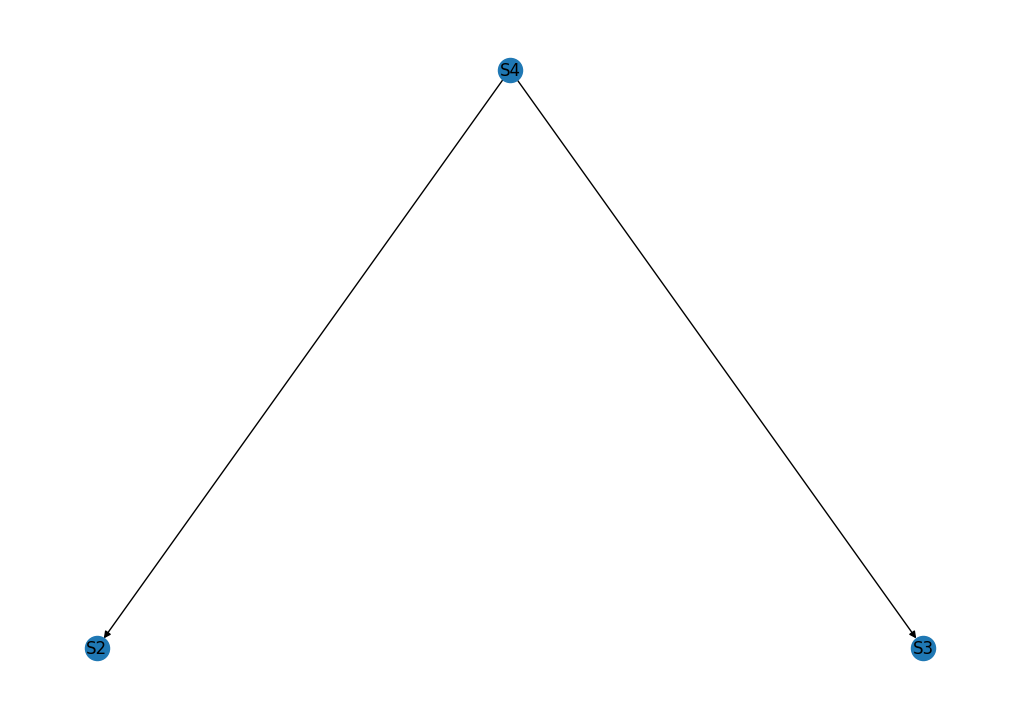

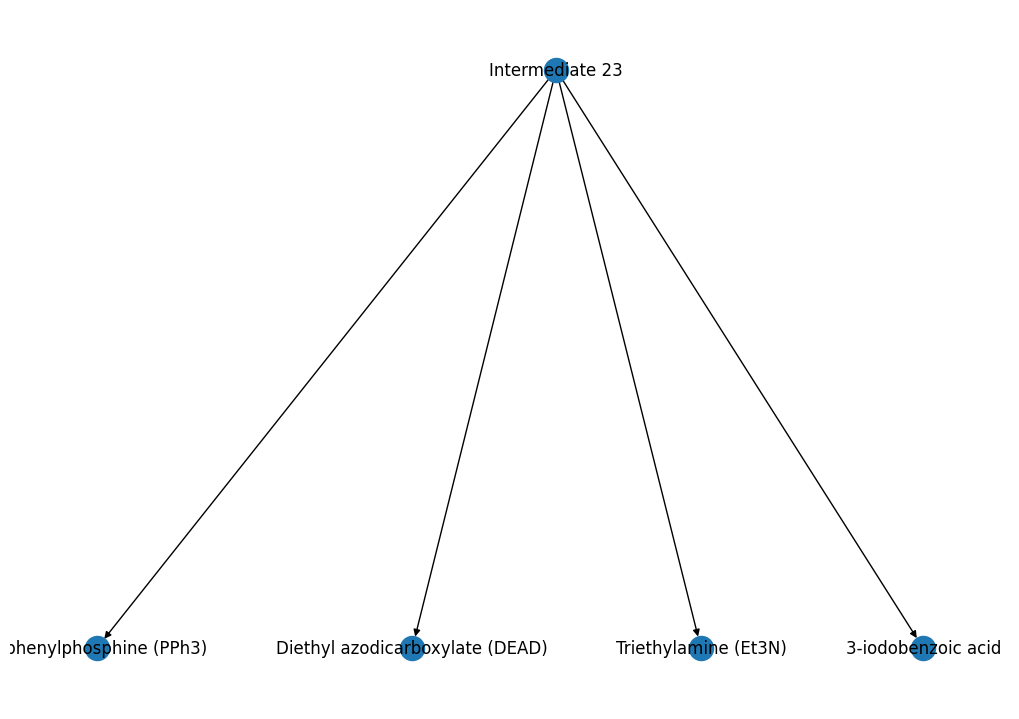

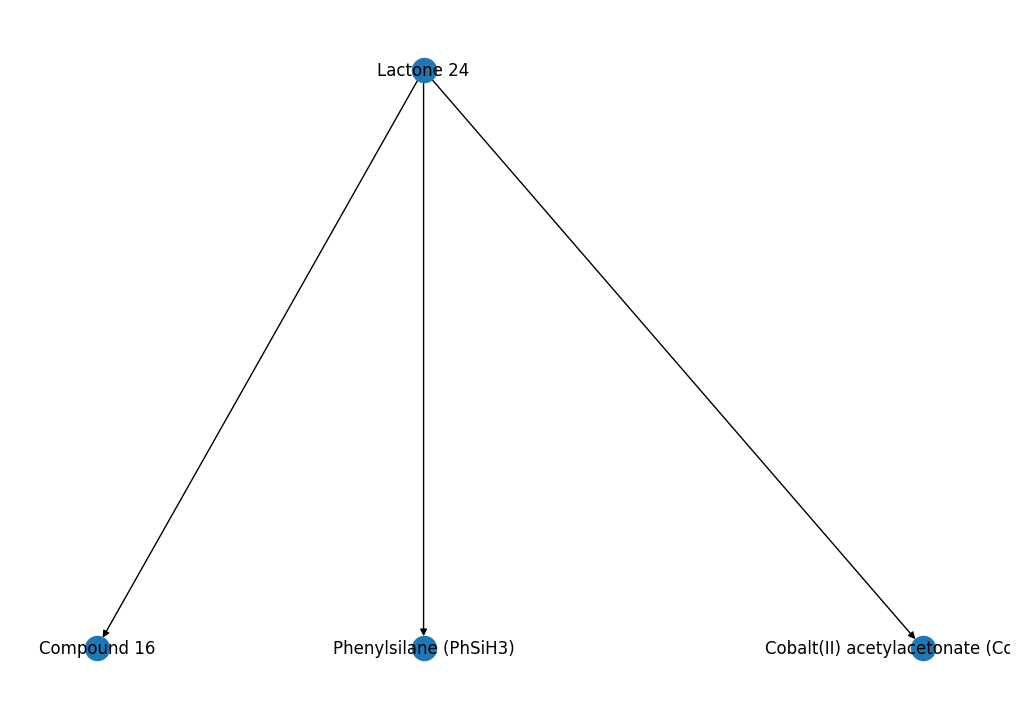

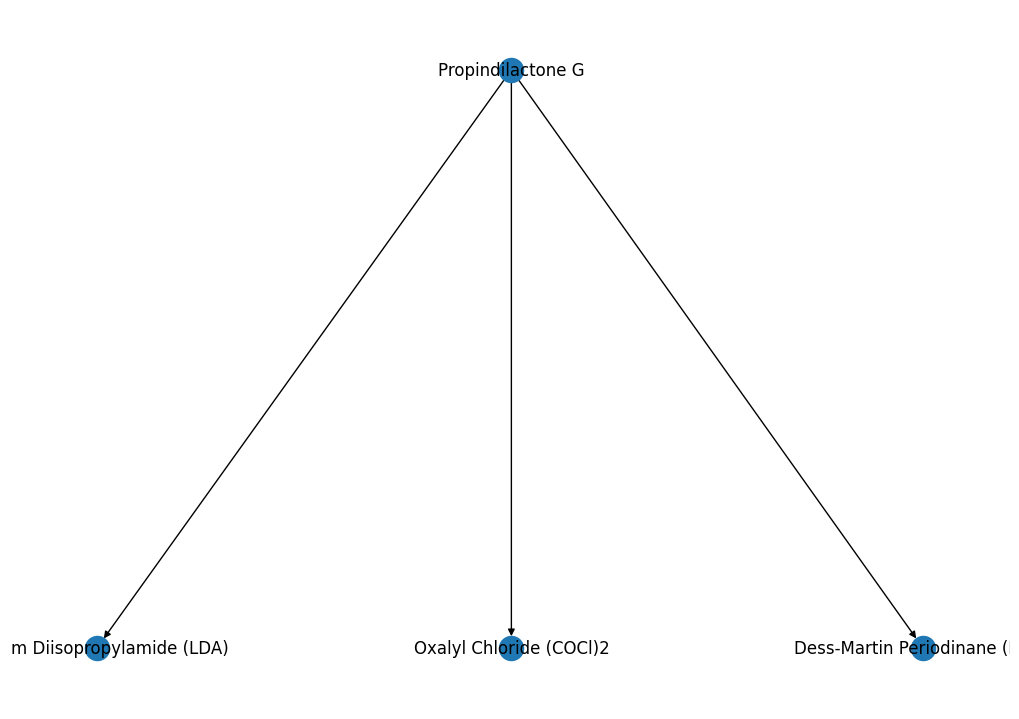

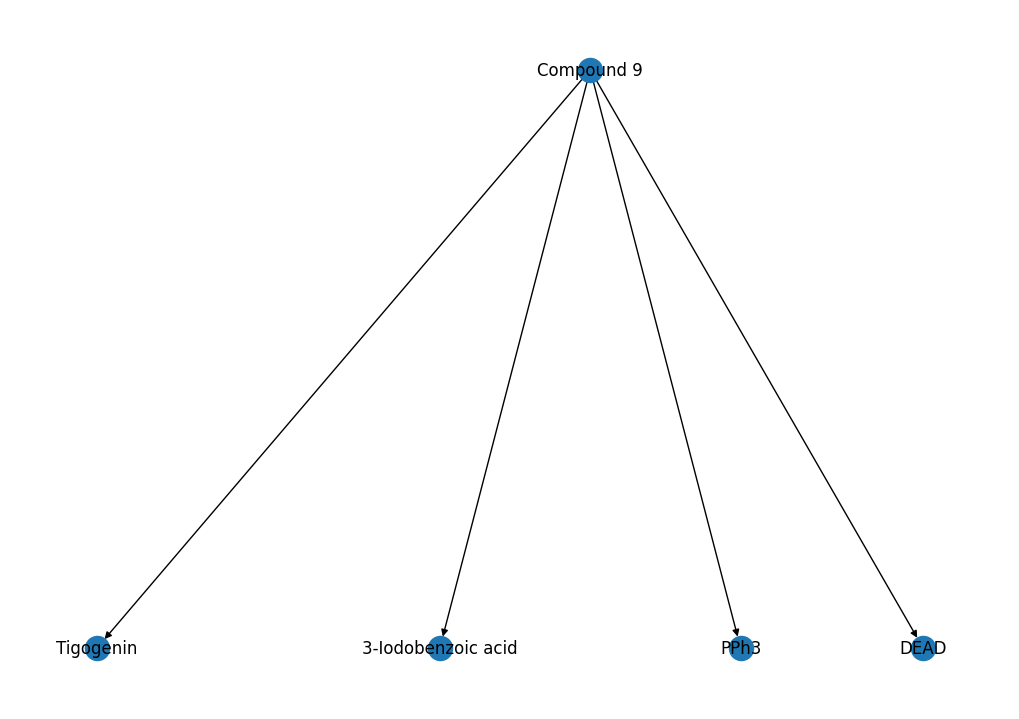

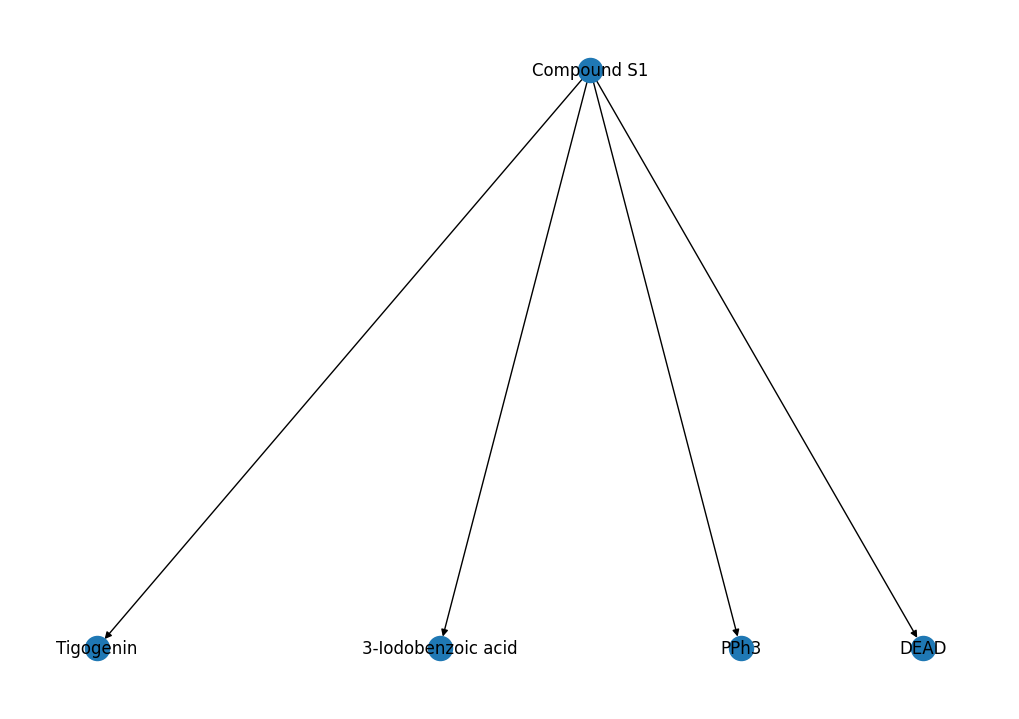

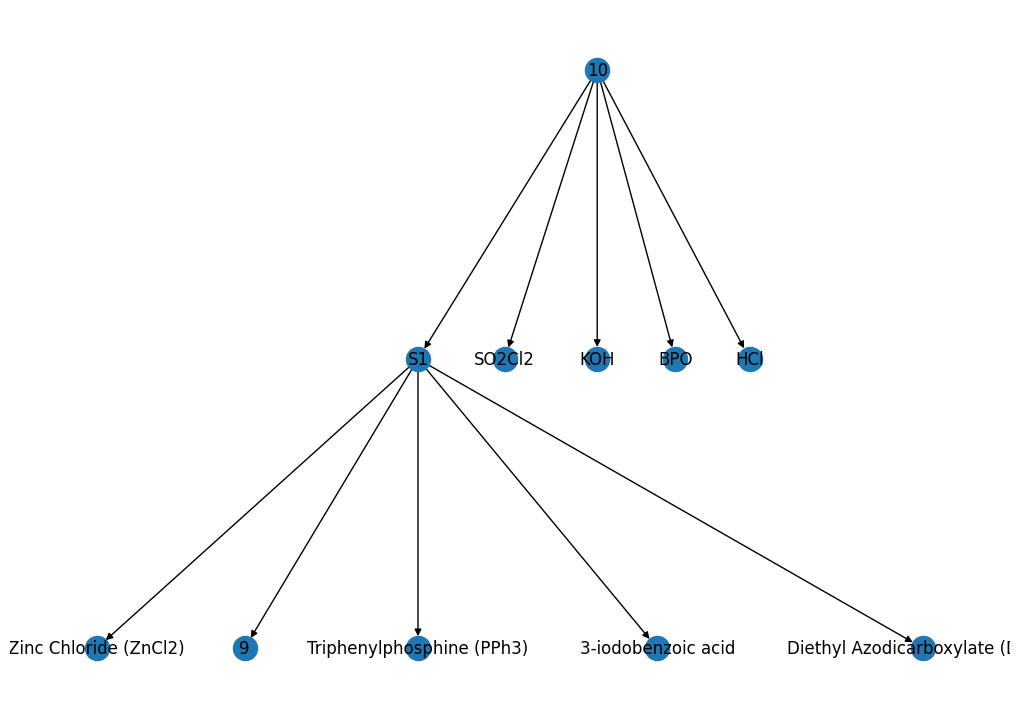

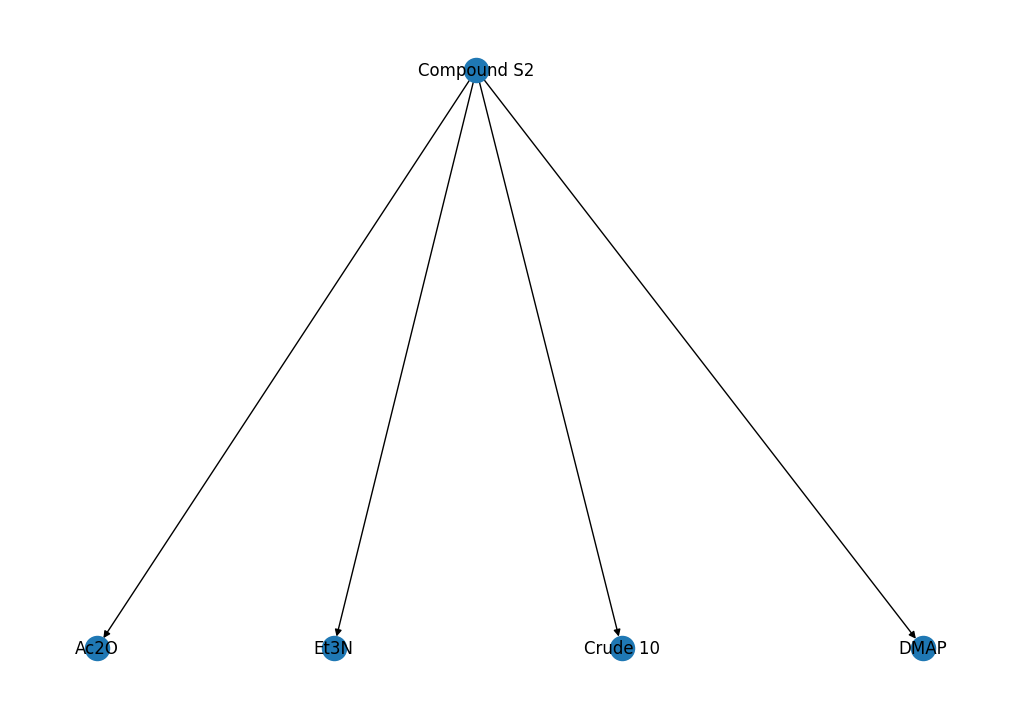

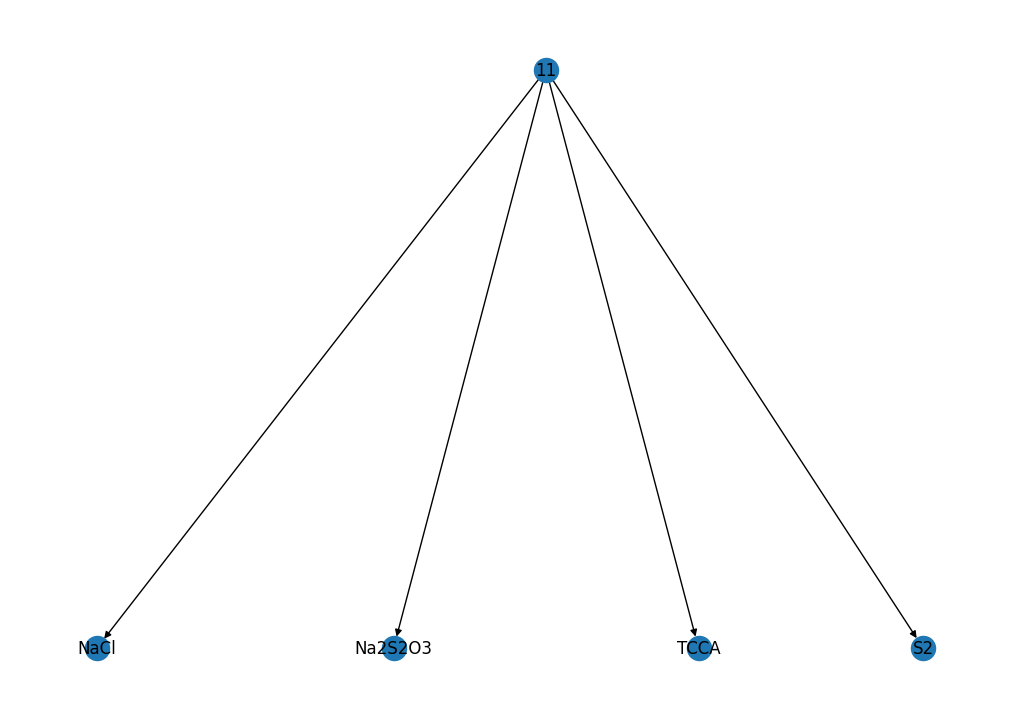

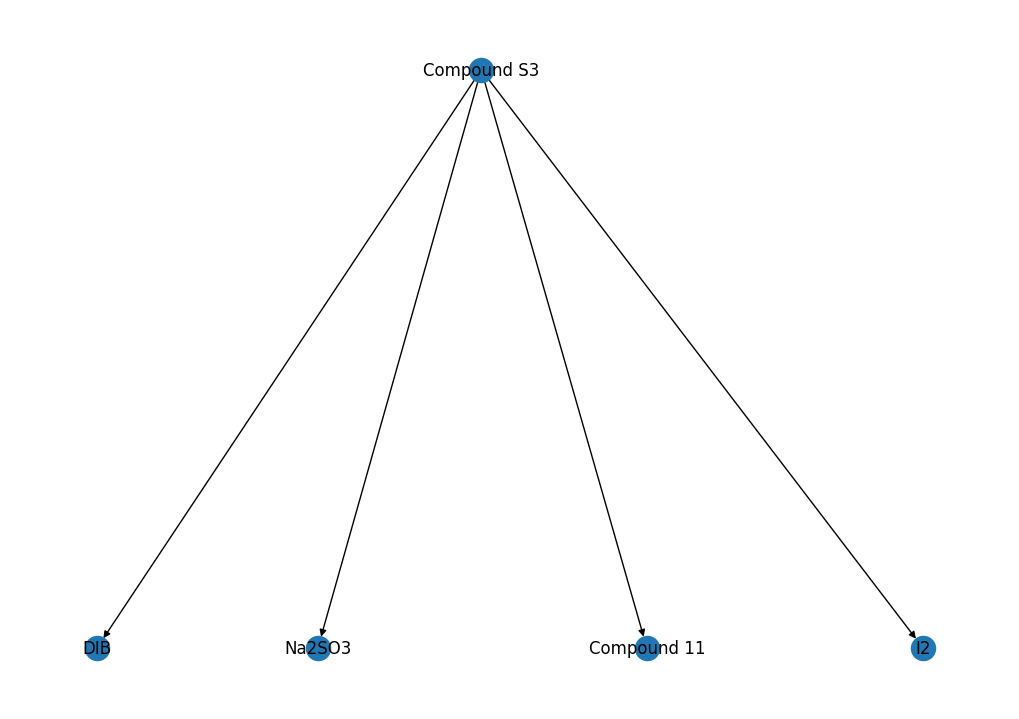

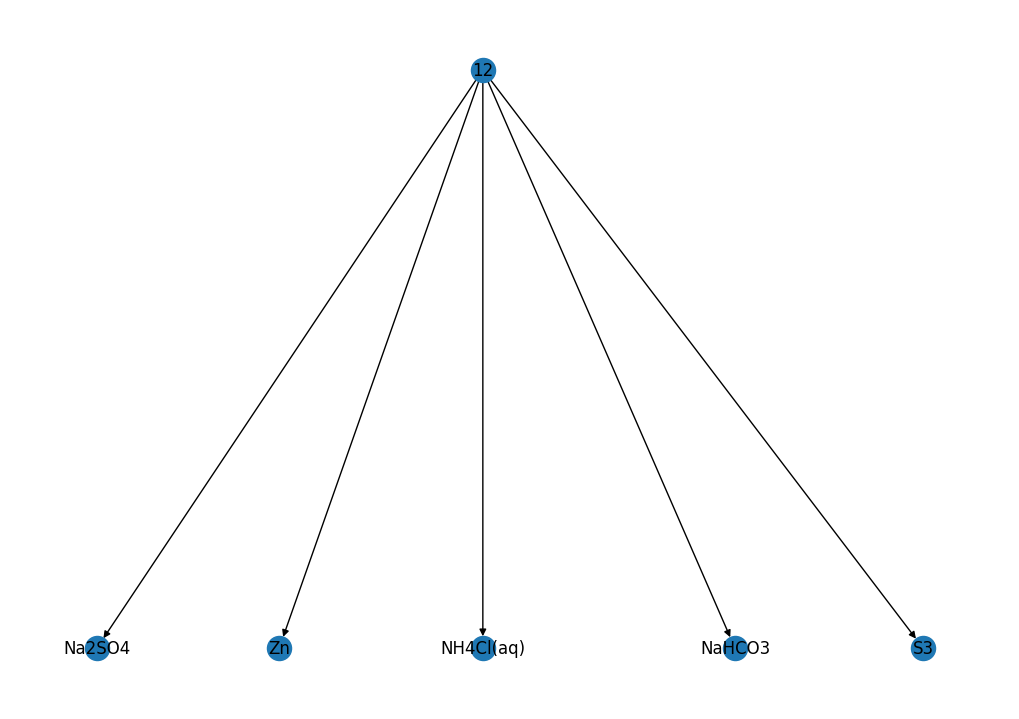

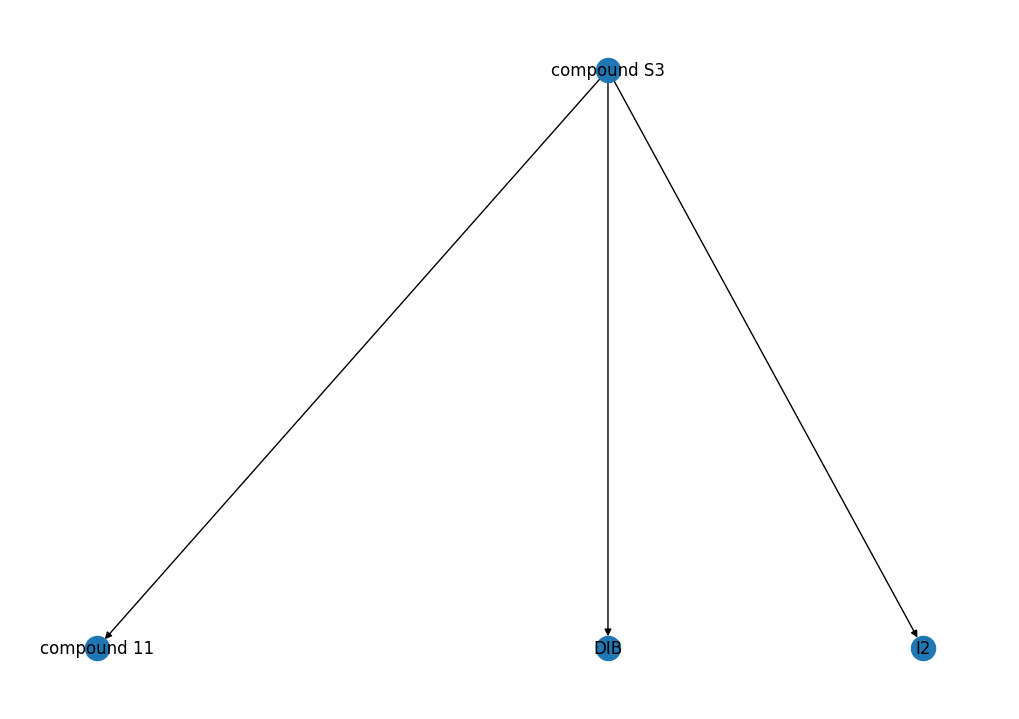

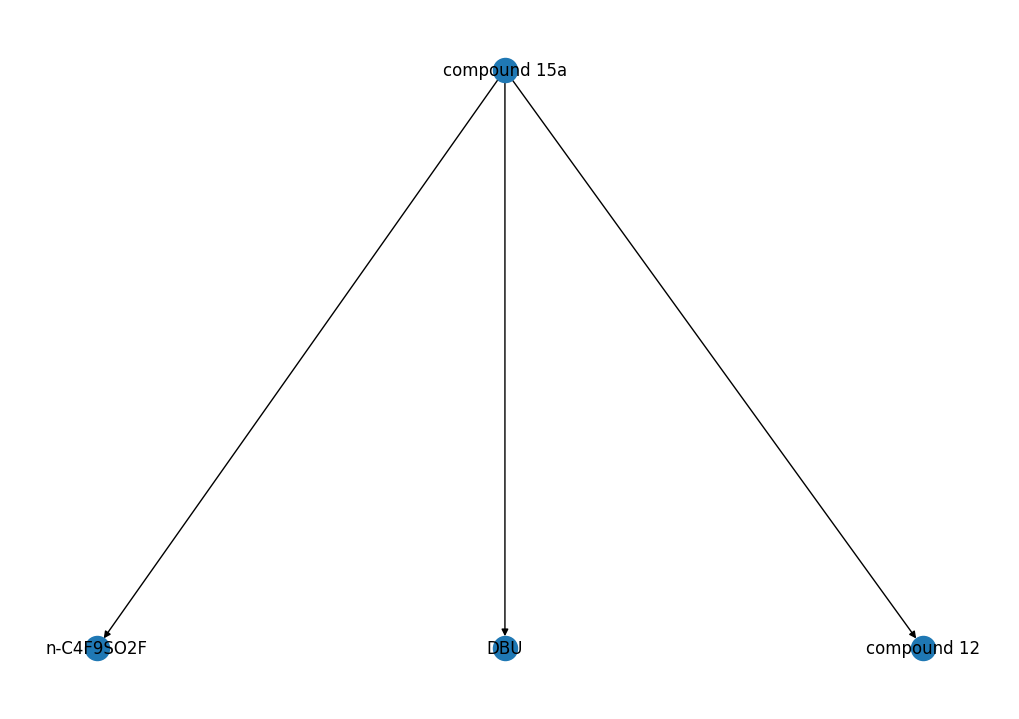

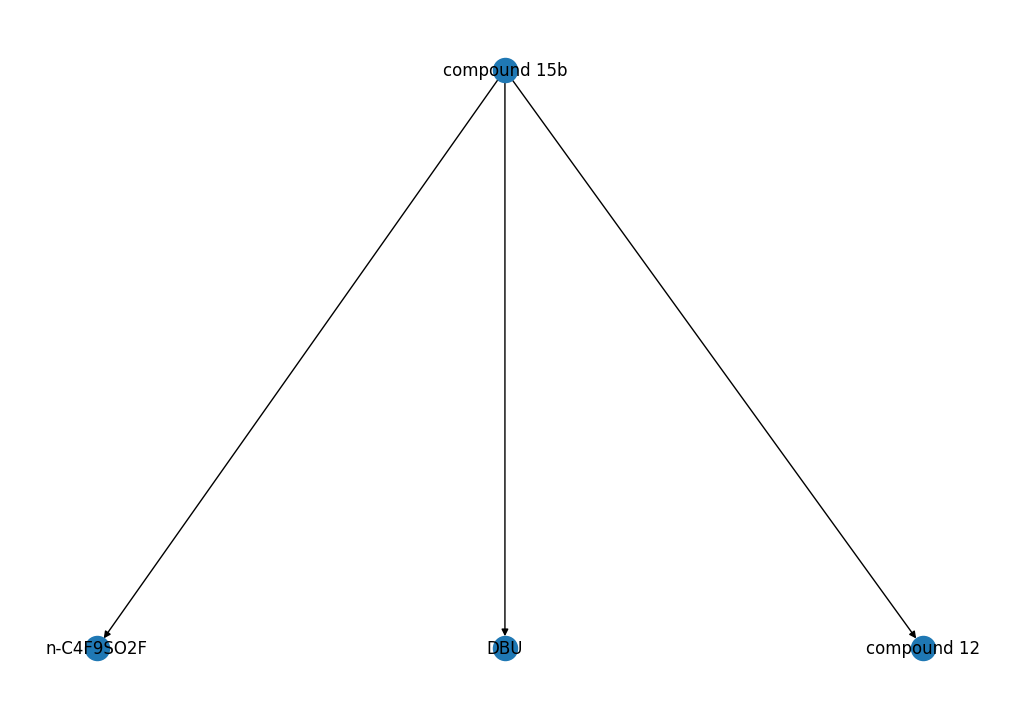

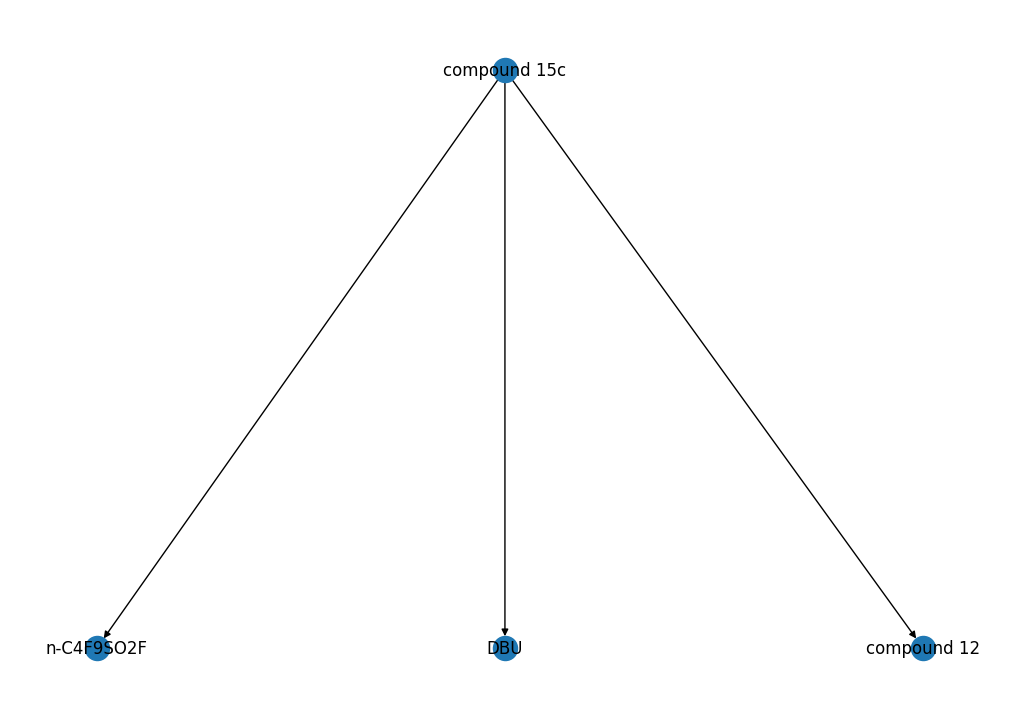

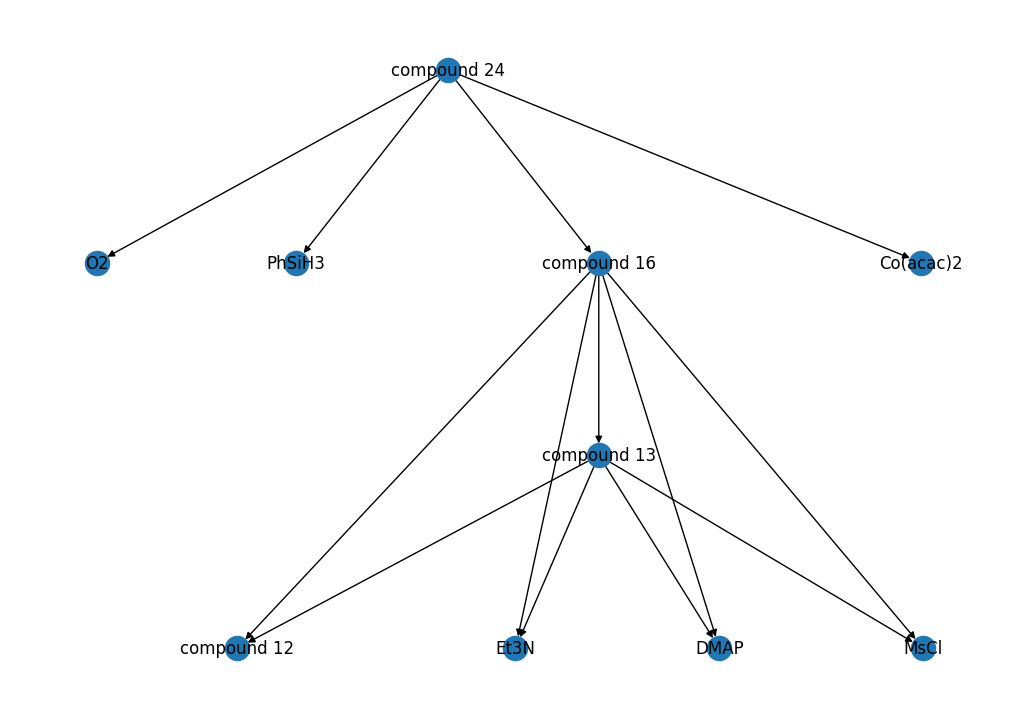

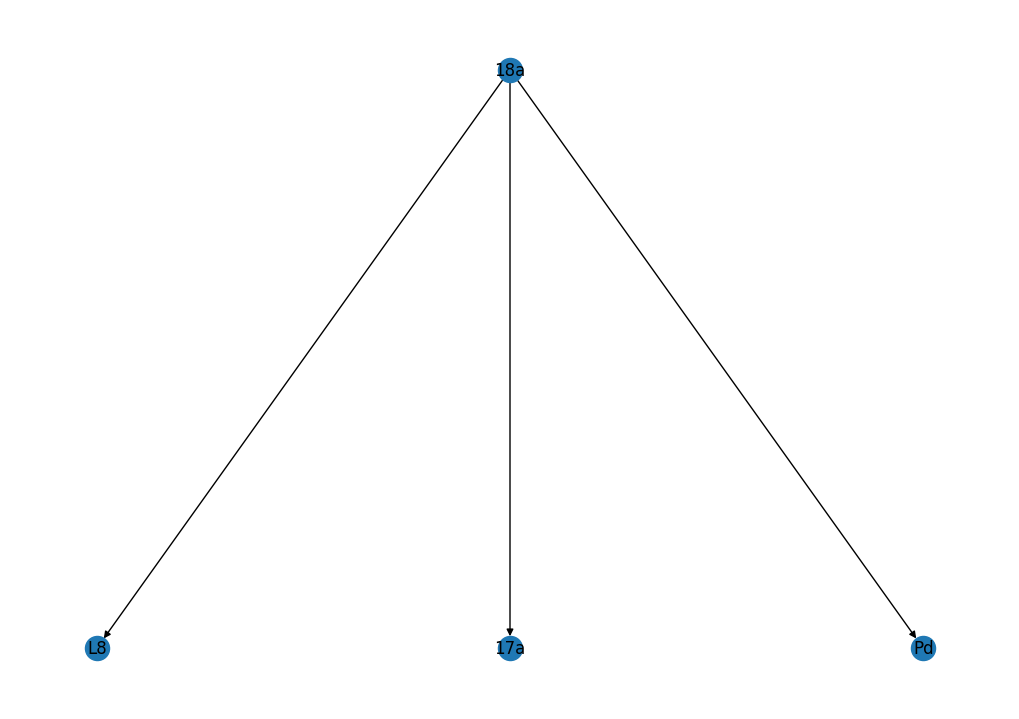

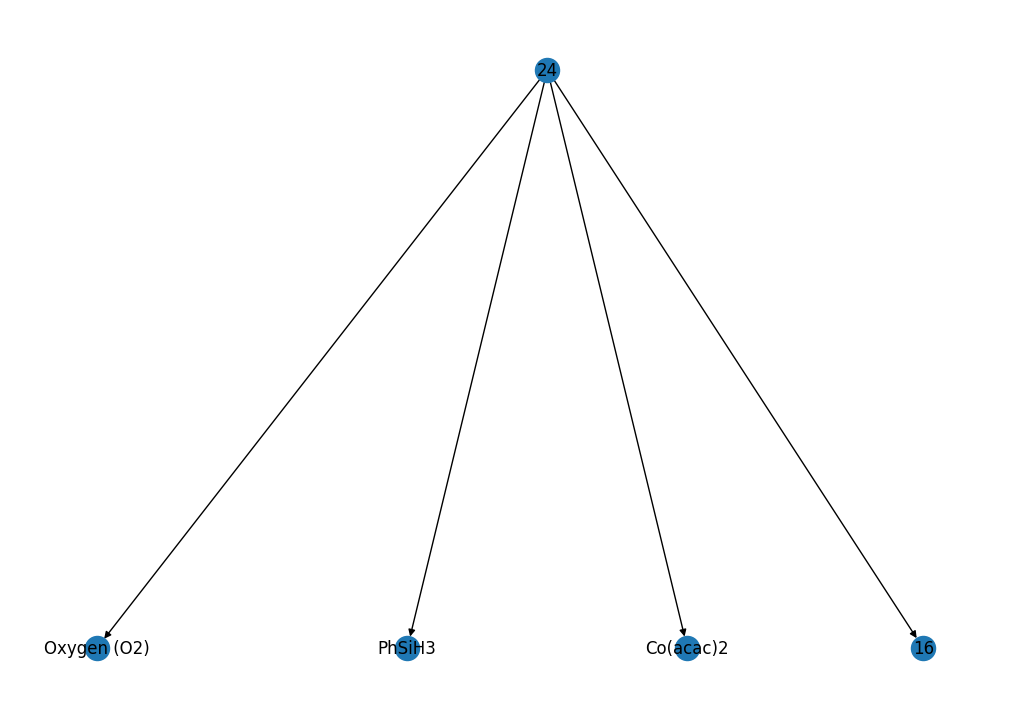

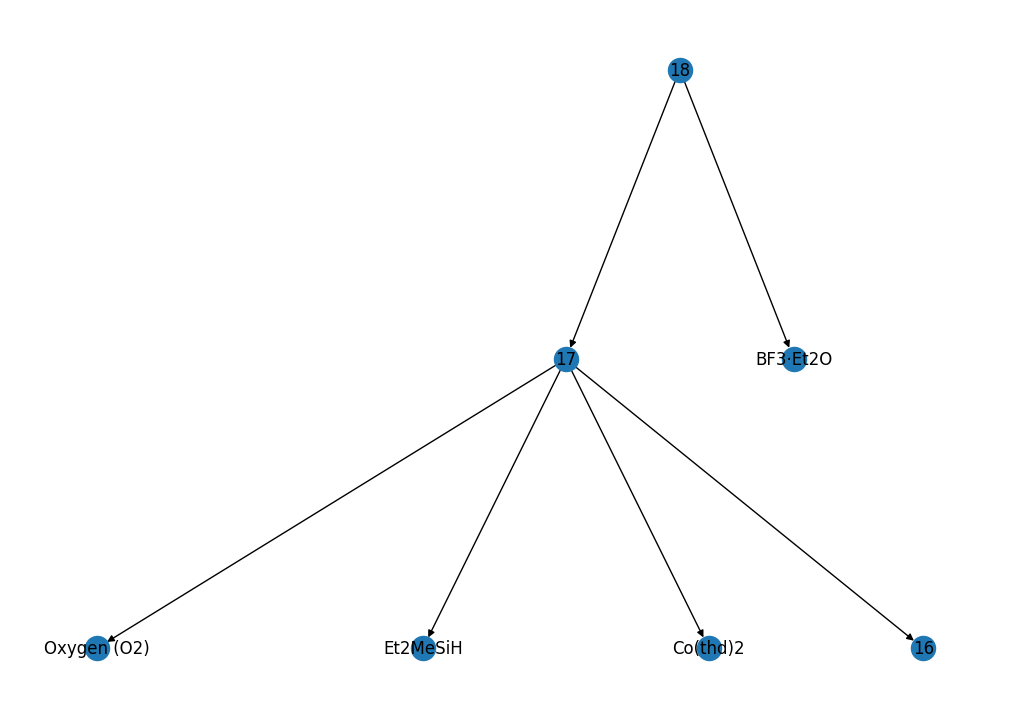

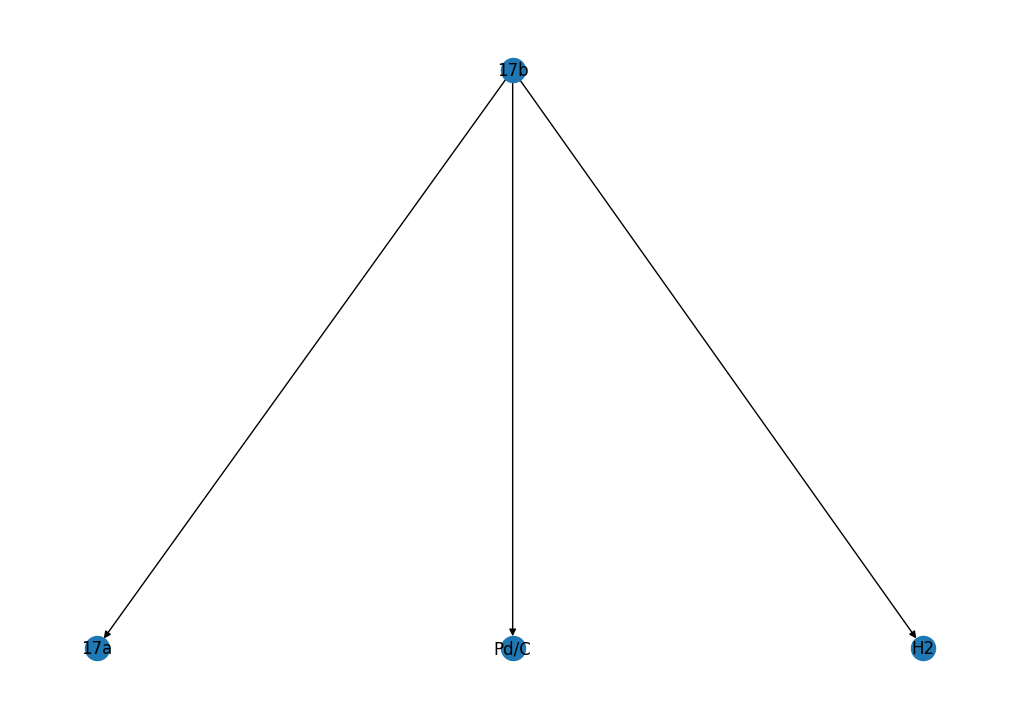

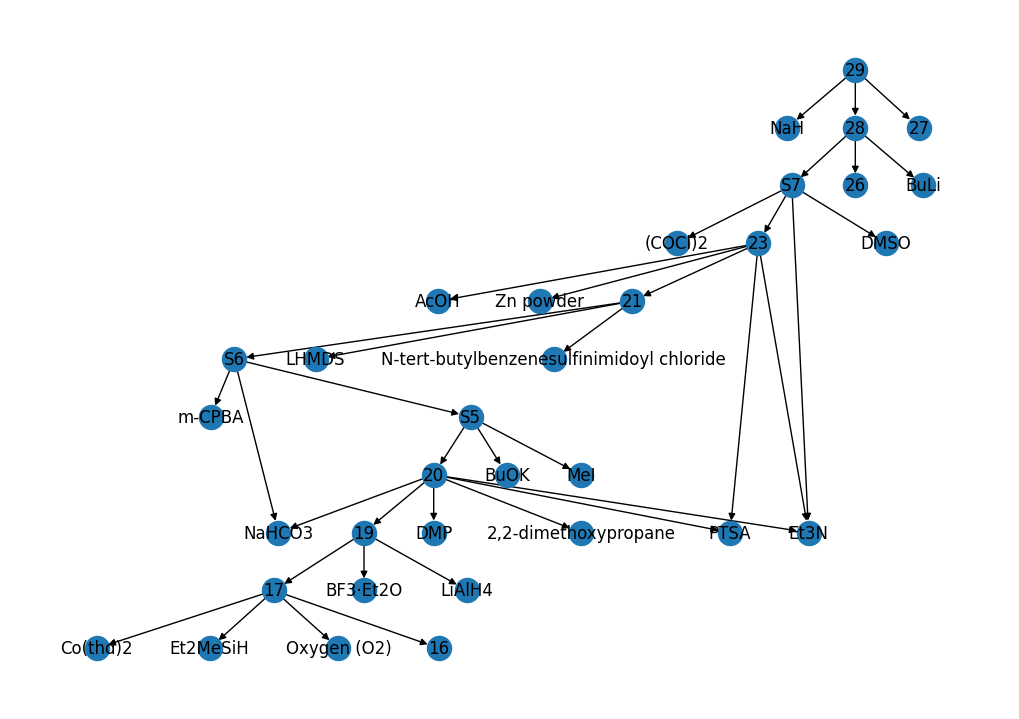

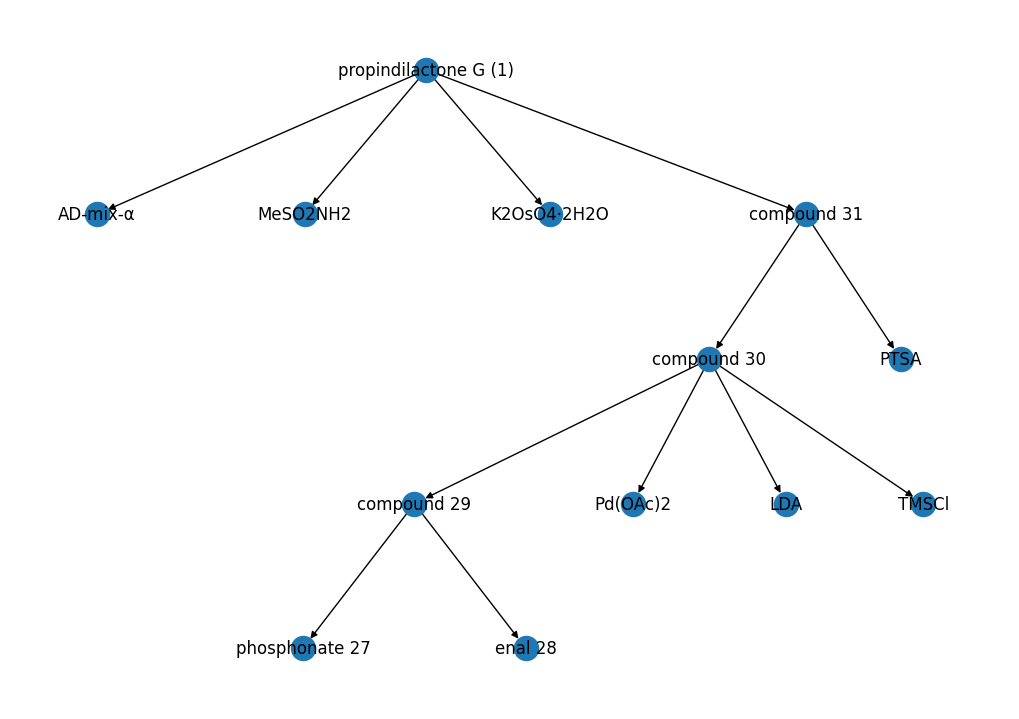

In [6]:
import matplotlib.pyplot as plt
import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout


def plot_graph(G):
    fig = plt.figure(figsize=(10, 7))
    pos = graphviz_layout(G, prog="dot")
    nx.draw(G, pos, with_labels=True, arrows=True)
    plt.show()


for g in reach_sgs.values():
    if len(g) > 1:
        plot_graph(g)

In [7]:
from jasyntho import SynthTree

papers = [
    "jacs.0c00363",
    "ja074300t",
    "ja512124c",
    "jacs.0c00308",
    "jacs.0c02143",
    "jacs.0c02513",
    "jacs.1c01356",
    "jacs.1c00293",
    "jacs.3c01991",
    "jacs.3c07019",
    "jacs.8b00148",
    "jacs.7b13260",
    "jacs.7b09929",
    "jacs.7b00807",
    "jacs.9b12546",
    "jacs.9b09699",
    "jacs.9b05013",
    "jacs.8b13029",
    "jacs.8b06755",
    "jacs.8b03015",
    "jacs.7b11299",
    "jacs.7b08749",
    "jacs.7b07724",
    "jacs.7b06055",
    "jacs.7b01454",
    "jacs.6b07846",
    "jacs.2c13889",
    "jacs.2c12529",
    "jacs.2c06934",
    "jacs.0c10122",
]

for paper in papers:
    tree = SynthTree.from_dir(f"../../with_sis/{paper}")
    print(tree)

doc_src='../../with_sis/jacs.0c00363' fitz_paper=Document('../../with_sis/jacs.0c00363/paper.pdf') fitz_si=Document(<new PDF, doc# 287>) paper='Bioinspired Synthesis of Nortriterpenoid Propindilactone G\nYu Wang,† Bo Chen,† Xubiao He, and Jinghan Gui*\nCite This: J. Am. Chem. Soc. 2020, 142, 5007−5012\nRead Online\nACCESS\nMetrics & More\nArticle Recommendations\n*\nsı\nSupporting Information\nABSTRACT: A concise bioinspired synthesis of Schisandra nortriterpenoid propindilactone G has been accomplished from a\nreadily accessible steroidal lactone. Key transformations include a Breslow remote functionalization, a Suárez remote radical\nfunctionalization, a ring expansion enabled by a Wagner−Meerwein rearrangement, a stereoinversion of a tertiary alcohol, and a\nbiomimetic transesteriﬁcation/oxa-Michael addition cascade. This work also provides experimental evidence of the putative\npropindilactone G biosynthesis pathway.\nS\nchisandra nortriterpenoids (or schinortriterpenoids), such\n

MuPDF error: format error: cmsOpenProfileFromMem failed
MuPDF error: format error: cmsOpenProfileFromMem failed


doc_src='../../with_sis/jacs.9b09699' fitz_paper=Document('../../with_sis/jacs.9b09699/paper.pdf') fitz_si=Document(<new PDF, doc# 332>) paper='Elucidation of the Structure of Pseudorubriﬂordilactone B by\nChemical Synthesis\nPeng Yang,†,‡,§,⊥Jian Li,‡,⊥Li Sun,# Ming Yao,‡ Xiang Zhang,‡ Wei-Lie Xiao,∥\nJian-Hua Wang,#\nPing Tian,*,† Han-Dong Sun,*,∥Pema-Tenzin Puno,*,∥\nand Ang Li*,‡,§\n†The Research Center of Chiral Drugs, Innovation Research Institute of Traditional Chinese Medicine, Shanghai University of\nTraditional Chinese Medicine, 1200 Cailun Road, Shanghai 201203, China\n‡State Key Laboratory of Bioorganic and Natural Products Chemistry, Center for Excellence in Molecular Synthesis, Shanghai\nInstitute of Organic Chemistry, University of Chinese Academy of Sciences, Chinese Academy of Sciences, 345 Lingling Road,\nShanghai 200032, China\n§Henan Institute of Advanced Technology, Zhengzhou University, Zhengzhou 450052, China\n#Key Laboratory of Molecular Virology and Immunology,